# simulators

> Simulates data for demands & merits
- order: 3

In [ ]:
#| default_exp simulators

In [ ]:
# Set up autoreload
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# from collections import namedtuple, defaultdict
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# from copy import copy
# import time
# import math
# from pprint import pprint
## !pip install -U "ray"
# import ray
# import json
import random

# from AIShiftScheduler_KE5.config import *
import AIShiftScheduler_KE5.config as cf
# from AIShiftScheduler_KE5.loader import *
import AIShiftScheduler_KE5.loader as ldr


len(RESOURCE_TYPES)=3
['Manager', 'AssistMngr', 'RetailAssoc']

len(TYPES)=13
['Manager', 'AssistMngr', 'AssistMngr', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc']
len(aNAMES)=13
['Manager_Matt', 'AssistMngr_Mike', 'AssistMngr_Tanner', 'RetailAssoc_Jake', 'RetailAssoc_James', 'RetailAssoc_Jane', 'RetailAssoc_John', 'RetailAssoc_Jim', 'RetailAssoc_Jenny', 'RetailAssoc_Jeremy', 'RetailAssoc_Judy', 'RetailAssoc_Julie', 'RetailAssoc_Jeffrey']

len(bNAMES)=3
['Manager', 'AssistMngr', 'RetailAssoc']

len(abNAMES)=13
['Manager_Matt___Manager', 'AssistMngr_Mike___AssistMngr', 'AssistMngr_Tanner___AssistMngr', 'RetailAssoc_Jake___RetailAssoc', 'RetailAssoc_James___RetailAssoc', 'RetailAssoc_Jane___RetailAssoc', 'RetailAssoc_John___RetailAssoc', 'RetailAssoc_Jim___RetailAssoc', 'RetailAssoc_Jenny___RetailAssoc', 'RetailAssoc_Jeremy___RetailAssoc', 'RetailAssoc_Judy___RetailAssoc', 'RetailAsso

In [ ]:
np.__version__

'1.24.4'

In [ ]:
# !pip freeze | grep pandas
# !pip freeze|grep openpyxl
# !pip freeze

In [ ]:
# !pip install -U ray==2.8.1
# !pip install openpyxl

In [ ]:
#| export
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## Demand simulation

In [ ]:
class DemandSimulator():
  def __init__(self,
    T__sim=cf.SIM_T,
    muD=cf.SIM_MU_D,
    eventTimeD=cf.SIM_EVENT_TIME_D,
    muDeltaD=cf.SIM_MU_DELTA_D,
    seed=None):
    self.time = 0
    self.T__sim = cf.SIM_T
    self.muD = cf.SIM_MU_D
    self.eventTimeD = cf.SIM_EVENT_TIME_D
    self.muDeltaD = cf.SIM_MU_DELTA_D
    self.prng = np.random.RandomState(seed)

  def simulate(self):
    if self.time > self.T__sim - 1:
      self.time = 0
    D_tt1 = {}
    for bn in cf.bNAMES:
      if self.eventTimeD[bn] and self.time > self.eventTimeD[bn]: ##event for entity
        D_tt1[bn] = self.muDeltaD[bn] + self.prng.poisson(self.muD[bn]) ##after event
      else:
        D_tt1[bn] = self.prng.poisson(self.muD[bn])
    self.time += 1
    return {bn: max(0, D_tt1[bn]) for bn in cf.bNAMES} ##always positive

### Example of usage

In [ ]:
dem_sim = DemandSimulator(seed=1234)
DemandData = []
for i in range(cf.SIM_T):
  d = list(dem_sim.simulate().values())
  DemandData.append(d)
labels = [f'{bn}_dem' for bn in cf.bNAMES]
df = pd.DataFrame.from_records(data=DemandData, columns=labels); df[:10]

,Manager_dem,AssistMngr_dem,RetailAssoc_dem
0,5,4,3
1,2,4,3
2,6,2,3
3,1,3,2
4,3,6,2
5,2,1,0
6,4,3,1
7,7,1,4
8,3,5,0
9,4,3,1


In [ ]:
def plot_output(df1, df2):
  n_charts = len(cf.bNAMES)
  ylabelsize = 16
  mpl.rcParams['lines.linewidth'] = 1.2
  default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  fig, axs = plt.subplots(n_charts, sharex=True)
  fig.set_figwidth(13); fig.set_figheight(9)
  fig.suptitle('Demand Simulation', fontsize=20)

  for i,bn in enumerate(cf.bNAMES):
    axs[i].set_title(f'Demanded {bn}')
    axs[i].set_ylim(auto=True); axs[i].spines['top'].set_visible(False); axs[i].spines['right'].set_visible(True); axs[i].spines['bottom'].set_visible(False)
    axs[i].step(df1[f'{bn}_dem'], 'r-')
    ## axs[i].axhline(y=dem_sim.muD[e], color='k', linestyle=':')
    axs[i].axhline(y=0, color='k', linestyle=':')

  axs[i].set_xlabel('$t\ \mathrm{[hourly\ windows]}$', rotation=0, ha='center', va='center', fontweight='bold', size=ylabelsize)

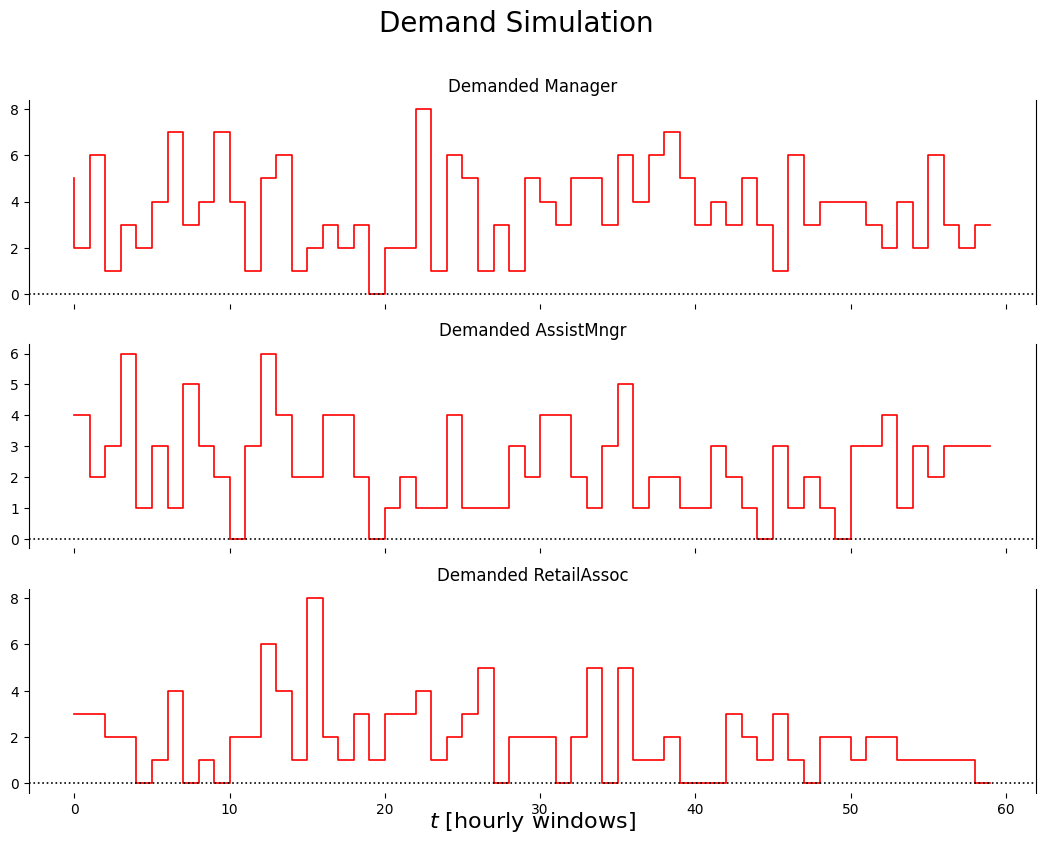

In [ ]:
plot_output(df, None)

## Merit simulation

In [ ]:
#/// MERIT_PROBS = load_merit_probs(f'{base_dir}/{file_name}')

In [ ]:
cf.MERIT_PROBS

,ResourceId,MeritProb,DemeritProb
0,1,0.0100,0.0400
1,2,0.2000,0.0900
2,3,0.3000,0.0300
3,4,0.2000,0.1500
4,5,0.0500,0.0200
5,6,0.1000,0.0100
6,7,0.2000,0.0200
7,8,0.3000,0.3000
8,9,0.2000,0.0100
9,10,0.0600,0.1200


In [ ]:
## copy from the generated file and paste into ExogInfo tab of shift_scheduler_data.xlsx
class MeritSimulator():
  def __init__(self, seed=None):
    self.prng = np.random.RandomState(seed)

  def simulate(self):
    M_tt1 = {}
    for an in cf.aNAMES:
      resourceId,_ = an.split('_')
      a,b = cf.MERIT_PROBS.loc[
        cf.MERIT_PROBS['ResourceId'] == resourceId,
        ['MeritProb', 'DemeritProb']
      ].values[0]
      if np.random.uniform() < a: merit = 1
      else: merit = 0
      if np.random.uniform() < b: demerit = 1
      else: demerit = 0
      M_tt1[an] = merit - demerit ##net merit
    return M_tt1

### Example of usage

In [ ]:
## breaks, need to fix
# ## copy from the generated file and paste into ExogInfo tab of shift_scheduler_data.xlsx
# mer_sim = MeritSimulator(seed=1234)
# MeritData = []
# # for i in range(100):
# for i in range(672):
#   mer = list(mer_sim.simulate().values())
#   MeritData.append(mer)
# labels = [f'{an}_merit' for an in cf.aNAMES]
# df = pd.DataFrame.from_records(data=MeritData, columns=labels); df[:10]

In [ ]:
# ////////////////////////////////////

In [ ]:
# cf.bNAMES

['Manager', 'AssistMngr', 'RetailAssoc']

In [ ]:
# an = cf.aNAMES[0]

In [ ]:
# # resourceId,_ = an.split('_'); resourceId
# _,resourceId = an.split('_'); resourceId

'Matt'

In [ ]:
# # MERIT_PROBS
# cf.MERIT_PROBS['ResourceId']

,ResourceId,MeritProb,DemeritProb
0,1,0.0100,0.0400
1,2,0.2000,0.0900
2,3,0.3000,0.0300
3,4,0.2000,0.1500
4,5,0.0500,0.0200
5,6,0.1000,0.0100
6,7,0.2000,0.0200
7,8,0.3000,0.3000
8,9,0.2000,0.0100
9,10,0.0600,0.1200


In [ ]:
# ///
# a,b = MERIT_PROBS.loc[
      #   MERIT_PROBS['ResourceId'] == resourceId,
      #   ['MeritProb', 'DemeritProb']
      # ].values[0]

In [ ]:
# aNAMES

['Manager_Matt',
 'AssistMngr_Mike',
 'AssistMngr_Tanner',
 'RetailAssoc_Jake',
 'RetailAssoc_James',
 'RetailAssoc_Jane',
 'RetailAssoc_John',
 'RetailAssoc_Jim',
 'RetailAssoc_Jenny',
 'RetailAssoc_Jeremy',
 'RetailAssoc_Judy',
 'RetailAssoc_Julie',
 'RetailAssoc_Jeffrey']

In [ ]:
# \\\\\\\\\\\\\\

In [ ]:
## copy from this file and paste into ExogInfo tab of shift_scheduler_data.xlsx
## df.to_excel('merits.xlsx', index=False)

In [ ]:
## breaks, need to fix
# import random
# def plot_output(df1, df2):
#   n_charts = len(cf.aNAMES)
#   ylabelsize = 16
#   mpl.rcParams['lines.linewidth'] = 1.2
#   default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#   fig, axs = plt.subplots(n_charts, sharex=True)
#   fig.set_figwidth(13); fig.set_figheight(9)
#   fig.suptitle('Merit Simulation', fontsize=20)

#   for i,an in enumerate(cf.aNAMES):
#     axs[i].set_title(f'Merits for {an}')
#     axs[i].set_ylim(-1, 1); axs[i].spines['top'].set_visible(False); axs[i].spines['right'].set_visible(True); axs[i].spines['bottom'].set_visible(False)
#     axs[i].step(df1[f'{an}_merit'], 'r-')
#     ## axs[i].axhline(y=dem_sim.muD[e], color='k', linestyle=':')
#     axs[i].axhline(y=0, color='k', linestyle=':')
#   axs[i].set_xlabel('$t\ \mathrm{[hourly\ windows]}$', rotation=0, ha='center', va='center', fontweight='bold', size=ylabelsize)
# plot_output(df, None)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()